In [3]:
import cv2
import numpy as np
import pywt
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

In [4]:
# Utility Functions...

def rgb_to_yiq(rgb_image):
    transformation_matrix = np.array([[0.299, 0.587, 0.114],
                                      [0.596, -0.275, -0.321],
                                      [0.212, -0.523, 0.311]])
    yiq_image = np.dot(rgb_image, transformation_matrix.T)
    return yiq_image

def yiq_to_rgb(yiq_image):
    transformation_matrix = np.array([[1.000, 0.956, 0.620],
                                      [1.000, -0.272, -0.647],
                                      [1.000, -1.108, 1.703]])
    rgb_image = np.dot(yiq_image, np.linalg.inv(transformation_matrix.T))
    return rgb_image

def normalize_2dshape(A, matrix):
    rows_diff = A.shape[0] - A.shape[0]
    cols_diff = matrix.shape[1] - matrix.shape[1]

    A = np.pad(matrix, ((rows_diff, 0), (cols_diff, 0)), mode='constant')
    return A

# modify normalize_2dshape for 3d matrix
def normalize_3dshape(A, matrix):
    rows_diff = A.shape[0] - A.shape[0]
    cols_diff = matrix.shape[1] - matrix.shape[1]

    A = np.pad(matrix, ((rows_diff, 0), (cols_diff, 0), (0, 0)), mode='constant')
    return A

def normalized_correlation(array1, array2):
    # Compute the cross-correlation between the two arrays
    corr = np.correlate(array1.ravel(), array2.ravel(), mode='same')
    
    # Compute the norms of the arrays
    norm1 = np.linalg.norm(array1)
    norm2 = np.linalg.norm(array2)
    
    # Compute the normalized correlation
    norm_corr = np.max(corr) / (norm1 * norm2)
    
    return norm_corr

def show_image_1(image, label):
      fig, axs = plt.subplots(1, 1, figsize=(4, 4))
      plt.subplots_adjust(wspace=0, hspace=0)

      axs.imshow(image, cmap='gray')
      axs.axis('off')
      axs.set_title(label)
      
      plt.show()

def show_image(images, labels, axes):
    fig, axs = plt.subplots(axes[0], axes[1], figsize=(6, 6))
    plt.subplots_adjust(wspace=0.25, hspace=0.25)
      
    if(sum(axes) == 2):
        axs.imshow(images[0], cmap='gray')
        axs.axis('off')
        axs.set_title(labels[0])
        
    elif(sum(axes) == 3):
        for i in range(len(images)):
            axs[i].imshow(images[i], cmap='gray')
            axs[i].axis('off')
            axs[i].set_title(labels[i])
            
    else:
        axis = [[0,0], [0,1], [1,0], [1,1]]
        
        axs[0, 0].imshow(images[0], cmap='gray')
        axs[0, 0].axis('off')
        axs[0, 0].set_title(labels[0])

        axs[0, 1].imshow(images[1], cmap='gray')
        axs[0, 1].axis('off')
        axs[0, 1].set_title(labels[1])

        axs[1, 0].imshow(images[2], cmap='gray')
        axs[1, 0].axis('off')
        axs[1, 0].set_title(labels[2])

        axs[1, 1].imshow(images[3], cmap='gray')
        axs[1, 1].axis('off')
        axs[1, 1].set_title(labels[3])
      
    plt.show()

In [5]:
# STEP 1 : LOAD HOST AND WATERMARK IMAGES

host_image = cv2.imread('./assets/host_image.png')
watermark_image = cv2.imread('./assets/watermark_image.png')

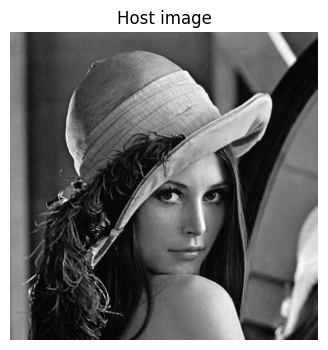

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


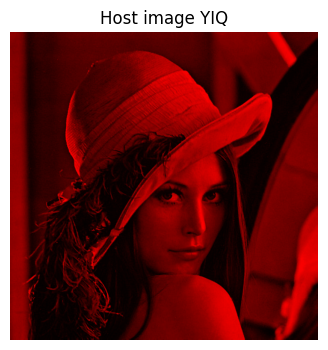

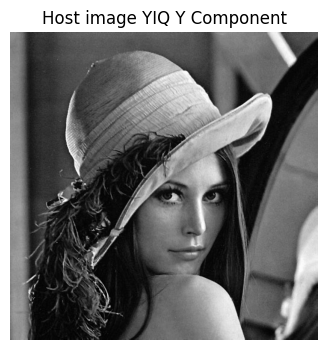

In [6]:
# CONVERT HOST IMAGE FROM RGB TO YIQ

host_image_yiq = rgb_to_yiq(host_image / 255.0)
host_image_yiq_y_comp = host_image_yiq[:, :, 0] # Extract Y component (luminance)

show_image_1(host_image, "Host image")
show_image_1(host_image_yiq, "Host image YIQ")
show_image_1(host_image_yiq_y_comp, "Host image YIQ Y Component")

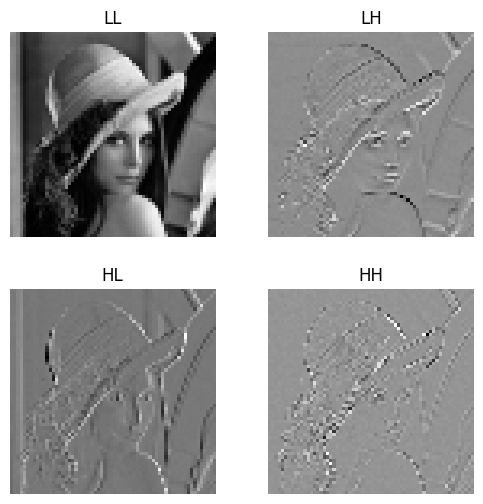

In [7]:
# APPLY 3 LEVEL DWT ON THE Y COMPONENT OBTAINED FROM THE YIQ HOST IMAGE

coeffs = pywt.wavedec2(host_image_yiq[:, :, 0], 'haar', level=3)
cA, (cH, cV, cD) = coeffs = coeffs[0], coeffs[1]

res = [cA, cH, cV, cD]
labels = ['LL', 'LH', 'HL', 'HH']

show_image(res, labels, [2,2])

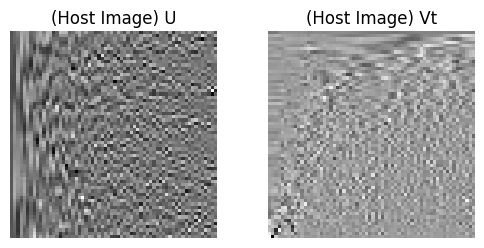

In [8]:
# APPLYING SVD ON THE COEFFICIENTS OBTAINED FROM DWT ABOVE

# for i in range(len(res)):
#     U, S, Vt = np.linalg.svd(res[i], full_matrices=False)
#     show_image([U, Vt], [f'(Host Image) U for {labels[i]}', f'(Host Image) Vt for {labels[i]}'], [1,2])

U, S, Vt = np.linalg.svd(cA, full_matrices=False)

show_image([U, Vt], [f'(Host Image) U', f'(Host Image) Vt'], [1,2])

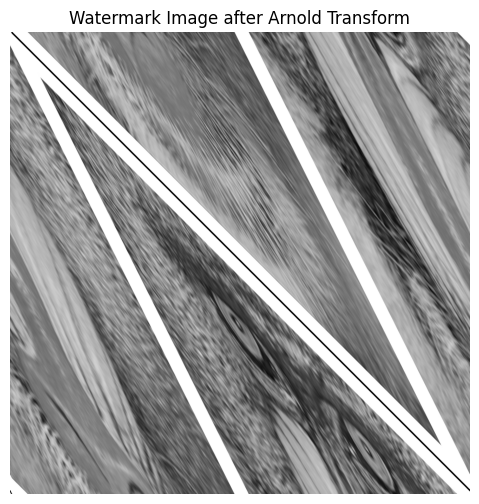

In [9]:
# APPLYING ARNOLD TRANSFORMATION ON THE WATERMARK IMAGE FOR IMAGE SCRAMBLING

def arnold_transform(image, iterations):
    # Get image dimensions
    height, width = image.shape[:2]

    # Perform Arnold transformation
    for index in range(iterations):
        new_image = np.zeros_like(image)
        for y in range(height):
            for x in range(width):
                new_x = (1 * x + 1 * y) % width
                new_y = (1 * x + 2 * y) % height
                new_image[new_y, new_x] = image[y, x]
        image = new_image

    return image

arnold_transformed_image = arnold_transform(watermark_image, 1)
show_image([arnold_transformed_image], ["Watermark Image after Arnold Transform"], [1,1])

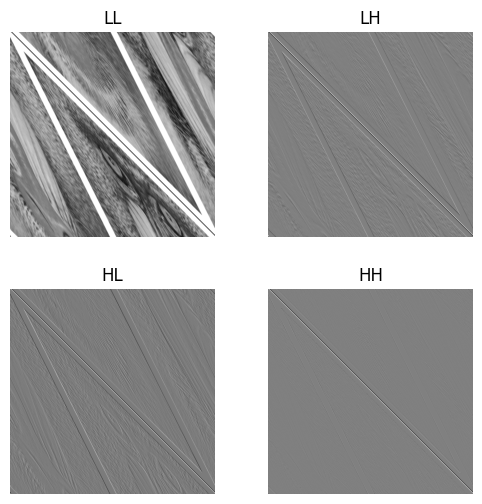

In [10]:
# APPLYING RGB TO YIQ CONVERSION AND THEN 1 LEVEL DWT ON THE SCRAMBLED WATERMARK IMAGE OBTAINED FROM ARNOLD TRANSFORMATION

arnold_y = rgb_to_yiq(arnold_transformed_image / 255.0)

coeffs_W = pywt.wavedec2(arnold_transformed_image[:, :, 0] if 1 else arnold_y[:, :, 0], 'haar', level=1)
cA_W, (cH_W, cV_W, cD_W) = coeffs_W = coeffs_W[0], coeffs_W[1]

res_w = [cA_W, cH_W, cV_W, cD_W]
labels = ['LL', 'LH', 'HL', 'HH']

show_image(res_w, labels, [2,2])

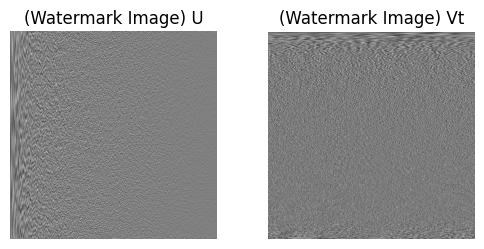

In [11]:
# APPLYING SVD ON THE COEFFICIENT OBTAINED AFTER THE 1 LEVEL DWT OPERATION ABOVE

# for i in range(len(res_w)):
#     Uw , Sw , VtW = np.linalg.svd(res_w[i], full_matrices=False)
#     show_image([Uw, VtW], [f'(Watermark Image) U for {labels[i]}', f'(Watermark Image) Vt for {labels[i]}'], [1,2])

Uw , Sw , VtW = np.linalg.svd(cA_W, full_matrices=False)

show_image([Uw, VtW], [f'(Watermark Image) U', f'(Watermark Image) Vt'], [1,2])

In [10]:
# USING DIFFERENTIAL EVOLUTION TO OBTAIN AN OPTIMIZED SCALING FACTOR

optimal_scale = 0.1
def objective_func(scale_factor, original_image, watermark_image):
    original_image = normalize_2dshape(original_image, watermark_image)
    watermarked_image = original_image + scale_factor * watermark_image
    
    norm_corr = normalized_correlation(original_image, watermarked_image)
    
    return -norm_corr

bounds = [(0, 1)]

result = differential_evolution(objective_func, bounds, args=(host_image[:,:,0], watermark_image[:,:,0]))
scale_factor = result.x

print(f"Optimal scaling factor: {scale_factor}")
print(f"Function value: {result.fun}")

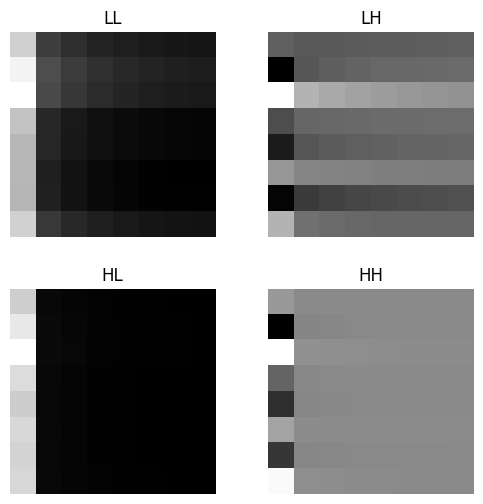

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


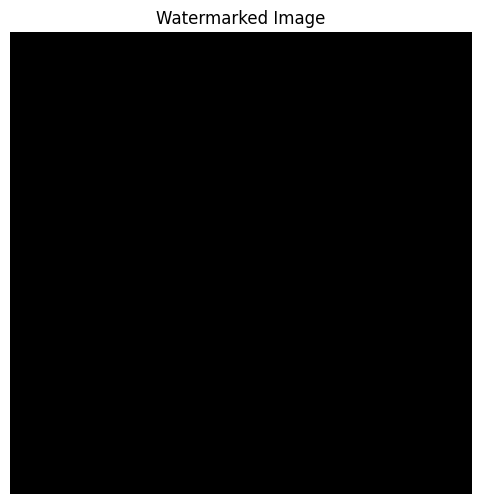

In [22]:
# EMBEDDING WATERMARK USING THE SCALING FACTOR OBTAINED FROM DE

def combine_convert(Yw, I, Q):
    Yw = normalize_2dshape(Yw, I)
    yiq_image = np.stack([Yw, I, Q], axis=-1)
    rgb_image = yiq_to_rgb(yiq_image / 255.0)

    return rgb_image

def watermark_embedding(U, S, Vt, watermark_matrix, scale_factor):
    S = np.pad(S, (0, (len(watermark_matrix)-len(S))))
    S_w = S + scale_factor * watermark_matrix # This S_w is a 1D list of length 425

    S_w = np.pad(S_w, (0, 64**2-len(S_w)))    
    S_w = np.reshape(S_w, (64, 64))
    U_w, S_w, Vt_w = np.linalg.svd(S_w, full_matrices=False)
    
    S_new = np.dot(U, np.dot(np.diag(S_w), Vt_w))
    
    # APPLY 3 LEVEL INVERSE DWT ON THE Y COMPONENT OBTAINED FROM S_NEW
    coeffst = pywt.wavedec2(S_new, 'haar', level=3)
    cAt, (cHt, cVt, cDt) = coeffst = coeffst[0], coeffst[1]

    res_t = [cAt, cHt, cVt, cDt]
    labels_t = ['LL', 'LH', 'HL', 'HH']

    show_image(res_t, labels_t, [2,2])
    
    # watermarked_matrix = np.dot(U, np.dot(S_new, Vt))
    watermarked_matrix = combine_convert(S_new, host_image_yiq[:, :, 1], host_image_yiq[:, :, 2])
    return watermarked_matrix

watermarked_cA = watermark_embedding(U, S, Vt, Sw, scale_factor=0.5)

show_image([watermarked_cA], ["Watermarked Image"], [1,1])